<a href="https://colab.research.google.com/github/ttchristian/CS-539-project/blob/main/EfficiencyNet/FruitDisease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install kaggle
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle (1).json


In [37]:
!kaggle datasets list -s fruit

ref                                               title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------  -----------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
muratkokludataset/date-fruit-datasets             Date Fruit Datasets                                  418144  2022-04-03 09:25:39.547000          27885       2131  0.9375           
chrisfilo/fruit-recognition                       Fruit Recognition                                8501391916  2020-02-04 18:52:00.330000          16209        354  0.875            
sshikamaru/fruit-recognition                      Fruit Classification                              107089100  2022-06-26 17:20:26.260000          18782        193  0.88235295       
moltean/fruits                                    Fruits-360 dataset                 

In [23]:
!mkdir -p ~/.kaggle

In [24]:
!cp kaggle.json ~/.kaggle/

In [25]:
!chmod 600 ~/.kaggle/kaggle.json

In [26]:
!kaggle datasets download -d muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten --unzip -p /content/data

Dataset URL: https://www.kaggle.com/datasets/muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten
License(s): CC0-1.0
100% 4.75G/4.77G [01:38<00:00, 61.8MB/s]
100% 4.77G/4.77G [01:38<00:00, 51.8MB/s]


In [36]:
import os
print("Contents of /content/data:")
for root, dirs, files in os.walk('/content/data'):
    level = root.replace('/content/data', '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files
        print(f'{subindent}{file}')
    if len(files) > 5:
        print(f'{subindent}... and {len(files)-5} more files')

Contents of /content/data:
data/
  Fruit And Vegetable Diseases Dataset/
    Tomato__Healthy/
      freshTomato (241).png
      freshTomato (73).png
      freshTomato (95).jpg
      freshTomato (141).png
      freshTomato (25).jpg
      ... and 599 more files
    Banana__Healthy/
      rotated_by_45_Screen Shot 2018-06-12 at 10.07.46 PM.png
      rotated_by_15_Screen Shot 2018-06-12 at 9.56.16 PM.png
      freshBanana (421).jpg
      freshBanana (394).jpg
      rotated_by_30_Screen Shot 2018-06-12 at 9.47.59 PM.png
      ... and 1995 more files
    Banana__Rotten/
      saltandpepper_Screen Shot 2018-06-12 at 9.20.20 PM.png
      vertical_flip_Screen Shot 2018-06-12 at 8.58.33 PM.png
      rotated_by_30_Screen Shot 2018-06-12 at 9.10.20 PM.png
      rotated_by_30_Screen Shot 2018-06-12 at 9.22.25 PM.png
      rotated_by_45_Screen Shot 2018-06-12 at 9.06.05 PM.png
      ... and 2795 more files
    Cucumber__Healthy/
      freshCucumber (354).jpg
      freshCucumber (542).jpg
      fresh

In [27]:
# Verify download
print("✅ Dataset downloaded!")
!ls /content/data | head -10

✅ Dataset downloaded!
Fruit And Vegetable Diseases Dataset


In [28]:
# Check GPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🚀 Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")


🚀 Using device: cuda
GPU: Tesla T4
GPU Memory: 14.7 GB


In [29]:
# =====================================
# CELL 2: Import Libraries
# =====================================

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time
from collections import defaultdict
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


In [43]:
# =====================================
# CELL 3: Configuration
# =====================================

class Config:
    # Paths
    DATA_DIR = "/content/data"

    # Training parameters (optimized for Colab)
    BATCH_SIZE = 16  # Higher batch size for GPU
    NUM_EPOCHS = 15  # Reasonable for Colab time limits
    LEARNING_RATE = 0.001
    IMG_SIZE = 224

    # Data split ratios
    TRAIN_RATIO = 0.7
    VAL_RATIO = 0.15
    TEST_RATIO = 0.15

    # Model parameters
    DROPOUT_RATE = 0.3

config = Config()
print(f"⚙️ Configuration set: {config.NUM_EPOCHS} epochs, batch size {config.BATCH_SIZE}")

⚙️ Configuration set: 15 epochs, batch size 16


In [31]:
# =====================================
# CELL 4: Dataset Class
# =====================================

class FreshGuardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.samples = []
        self.classes = []
        self.class_to_idx = {}

        self._load_samples()

    def _load_samples(self):
        """Load all image paths and create class mappings"""
        print(f"📁 Loading dataset from: {self.data_dir}")

        # Get all class directories
        class_dirs = []
        for item in os.listdir(self.data_dir):
            item_path = os.path.join(self.data_dir, item)
            if os.path.isdir(item_path):
                class_dirs.append(item)

        class_dirs = sorted(class_dirs)

        # Create class mappings
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_dirs)}
        self.classes = class_dirs

        print(f"Found {len(self.classes)} classes:")

        # Load all samples
        total_images = 0
        for class_name in class_dirs:
            class_dir = os.path.join(self.data_dir, class_name)
            class_idx = self.class_to_idx[class_name]

            # Get all image files
            image_files = []
            for file in os.listdir(class_dir):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_files.append(file)

            # Add to samples
            for img_file in image_files:
                img_path = os.path.join(class_dir, img_file)
                self.samples.append((img_path, class_idx))

            print(f"  📸 {class_name}: {len(image_files)} images")
            total_images += len(image_files)

        print(f"📊 Total samples: {total_images:,}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"❌ Error loading {img_path}: {e}")
            blank_image = Image.new('RGB', (224, 224), color='white')
            if self.transform:
                blank_image = self.transform(blank_image)
            return blank_image, label

In [32]:

# =====================================
# CELL 5: Data Transforms and Splits
# =====================================

def get_transforms():
    """Get training and validation transforms"""
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform

def create_data_splits(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """Split dataset into train, validation, and test sets"""
    print("\n🔄 Creating data splits...")

    indices = list(range(len(dataset)))
    labels = [dataset.samples[i][1] for i in indices]

    # First split: separate test set
    train_val_indices, test_indices = train_test_split(
        indices, test_size=test_ratio, random_state=42, stratify=labels
    )

    # Second split: separate train and validation
    train_val_labels = [labels[i] for i in train_val_indices]
    val_size = val_ratio / (train_ratio + val_ratio)

    train_indices, val_indices = train_test_split(
        train_val_indices, test_size=val_size, random_state=42, stratify=train_val_labels
    )

    print(f"📊 Dataset Split Summary:")
    print(f"  Total samples: {len(indices):,}")
    print(f"  Train: {len(train_indices):,} ({len(train_indices)/len(indices):.1%})")
    print(f"  Validation: {len(val_indices):,} ({len(val_indices)/len(indices):.1%})")
    print(f"  Test: {len(test_indices):,} ({len(test_indices)/len(indices):.1%})")

    return train_indices, val_indices, test_indices

In [33]:
# =====================================
# CELL 6: Model Definition
# =====================================

class FreshGuardEfficientNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.3):
        super(FreshGuardEfficientNet, self).__init__()

        # Load pre-trained EfficientNet-B0
        self.backbone = models.efficientnet_b0(weights='DEFAULT')

        # Get number of features
        num_features = self.backbone.classifier[1].in_features

        # Replace classifier
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.7),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)


In [34]:
# =====================================
# CELL 7: Training Function
# =====================================

def train_model(model, train_loader, val_loader, device, num_epochs=12):
    """Training function optimized for Colab"""

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    history = defaultdict(list)
    best_val_acc = 0.0

    print(f"\n🚀 Starting training for {num_epochs} epochs on {device}...")
    print("=" * 70)

    for epoch in range(num_epochs):
        start_time = time.time()

        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for batch_idx, (data, target) in enumerate(train_bar):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

            # Update progress bar
            train_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*train_correct/train_total:.2f}%'
            })

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            for data, target in val_bar:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

                val_bar.set_postfix({'Acc': f'{100.*val_correct/val_total:.2f}%'})

        # Calculate metrics
        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), '/content/best_freshguard_model.pth')
            print(f"💾 New best model saved! Val Acc: {val_acc:.4f}")

        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print epoch results
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1:2d}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
              f"Time: {epoch_time:.1f}s")

    print("=" * 70)
    print(f"🎉 Training completed! Best validation accuracy: {best_val_acc:.4f}")

    return history, best_val_acc

In [38]:
# =====================================
# CELL 8: Load Data and Create Model (FIXED VERSION)
# =====================================

# First, let's check the actual data structure
print("🔍 Checking data structure...")
data_root = "/content/data"

# Find the actual dataset folder
dataset_folders = []
for item in os.listdir(data_root):
    item_path = os.path.join(data_root, item)
    if os.path.isdir(item_path):
        # Check if this folder contains class folders
        subfolders = [f for f in os.listdir(item_path) if os.path.isdir(os.path.join(item_path, f))]
        if len(subfolders) > 1:  # Likely contains class folders
            dataset_folders.append(item_path)
            print(f"Found dataset folder: {item_path}")

# Use the first dataset folder found, or fall back to original
if dataset_folders:
    config.DATA_DIR = dataset_folders[0]
    print(f"✅ Using dataset path: {config.DATA_DIR}")
else:
    # If no nested folder, use the original path
    print(f"Using original path: {config.DATA_DIR}")

# Load dataset
print("\n📁 Loading dataset...")
train_transform, val_transform = get_transforms()

# Load full dataset to get class info
full_dataset = FreshGuardDataset(config.DATA_DIR, transform=None)
num_classes = len(full_dataset.classes)
class_names = full_dataset.classes

print(f"\n🏷️ Dataset Info:")
print(f"  Classes: {num_classes}")
print(f"  Class names: {class_names}")
print(f"  Total images: {len(full_dataset):,}")

# Only proceed if we have data
if len(full_dataset) == 0:
    print("❌ No images found! Let's check the folder structure...")

    # Debug: List all folders in data directory
    for root, dirs, files in os.walk(config.DATA_DIR):
        if dirs:
            print(f"Folder: {root}")
            print(f"  Subfolders: {dirs[:10]}")  # Show first 10
        if files:
            image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            if image_files:
                print(f"  Images: {len(image_files)}")
                break

    raise ValueError("No images found in dataset!")

# Create data splits
train_indices, val_indices, test_indices = create_data_splits(full_dataset)

# Create datasets with transforms
train_dataset = FreshGuardDataset(config.DATA_DIR, transform=train_transform)
val_dataset = FreshGuardDataset(config.DATA_DIR, transform=val_transform)
test_dataset = FreshGuardDataset(config.DATA_DIR, transform=val_transform)

# Create data subsets
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)
test_subset = Subset(test_dataset, test_indices)

# Create data loaders
train_loader = DataLoader(train_subset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_subset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\n📦 Data Loaders:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Create model
print(f"\n🤖 Creating EfficientNet-B0 model...")
model = FreshGuardEfficientNet(num_classes=num_classes, dropout_rate=config.DROPOUT_RATE).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: ~{total_params * 4 / 1024 / 1024:.1f} MB")

print(f"\n🎉 Dataset loaded successfully!")
print(f"📊 Ready to train on {num_classes} classes with {len(full_dataset):,} total images!")

🔍 Checking data structure...
Found dataset folder: /content/data/Fruit And Vegetable Diseases Dataset
✅ Using dataset path: /content/data/Fruit And Vegetable Diseases Dataset

📁 Loading dataset...
📁 Loading dataset from: /content/data/Fruit And Vegetable Diseases Dataset
Found 28 classes:
  📸 Apple__Healthy: 2438 images
  📸 Apple__Rotten: 2925 images
  📸 Banana__Healthy: 1999 images
  📸 Banana__Rotten: 2797 images
  📸 Bellpepper__Healthy: 611 images
  📸 Bellpepper__Rotten: 591 images
  📸 Carrot__Healthy: 619 images
  📸 Carrot__Rotten: 579 images
  📸 Cucumber__Healthy: 608 images
  📸 Cucumber__Rotten: 593 images
  📸 Grape__Healthy: 200 images
  📸 Grape__Rotten: 200 images
  📸 Guava__Healthy: 200 images
  📸 Guava__Rotten: 200 images
  📸 Jujube__Healthy: 200 images
  📸 Jujube__Rotten: 200 images
  📸 Mango__Healthy: 1813 images
  📸 Mango__Rotten: 2247 images
  📸 Orange__Healthy: 2075 images
  📸 Orange__Rotten: 2186 images
  📸 Pomegranate__Healthy: 200 images
  📸 Pomegranate__Rotten: 200 im

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 138MB/s]


  Total parameters: 4,801,944
  Trainable parameters: 4,801,944
  Model size: ~18.3 MB

🎉 Dataset loaded successfully!
📊 Ready to train on 28 classes with 29,277 total images!


In [39]:
# =====================================
# CELL 9: Train the Model
# =====================================

# Start training
print(f"\n🔥 Starting training on {device}...")
history, best_val_acc = train_model(model, train_loader, val_loader, device, config.NUM_EPOCHS)


🔥 Starting training on cuda...

🚀 Starting training for 5 epochs on cuda...


Epoch 1/5 [Val]: 100%|██████████| 275/275 [00:51<00:00,  5.32it/s, Acc=84.08%]


💾 New best model saved! Val Acc: 0.8408
Epoch  1/5 | Train Loss: 0.9112 | Train Acc: 0.7308 | Val Loss: 0.4627 | Val Acc: 0.8408 | Time: 410.7s


Epoch 2/5 [Val]: 100%|██████████| 275/275 [00:51<00:00,  5.36it/s, Acc=91.48%]


💾 New best model saved! Val Acc: 0.9148
Epoch  2/5 | Train Loss: 0.5172 | Train Acc: 0.8441 | Val Loss: 0.2552 | Val Acc: 0.9148 | Time: 403.8s


Epoch 3/5 [Val]: 100%|██████████| 275/275 [00:51<00:00,  5.36it/s, Acc=90.76%]


Epoch  3/5 | Train Loss: 0.4136 | Train Acc: 0.8735 | Val Loss: 0.2934 | Val Acc: 0.9076 | Time: 402.7s


Epoch 4/5 [Val]: 100%|██████████| 275/275 [00:51<00:00,  5.37it/s, Acc=91.17%]


Epoch  4/5 | Train Loss: 0.3735 | Train Acc: 0.8895 | Val Loss: 0.3384 | Val Acc: 0.9117 | Time: 402.6s


Epoch 5/5 [Val]: 100%|██████████| 275/275 [00:51<00:00,  5.38it/s, Acc=93.15%]

💾 New best model saved! Val Acc: 0.9315
Epoch  5/5 | Train Loss: 0.3374 | Train Acc: 0.8998 | Val Loss: 0.2342 | Val Acc: 0.9315 | Time: 403.4s
🎉 Training completed! Best validation accuracy: 0.9315



📈 Loading best model for final evaluation...
🎯 Final test evaluation...


Testing: 100%|██████████| 275/275 [00:51<00:00,  5.32it/s]



🏆 Final Results:
  Best Validation Accuracy: 0.9315 (93.15%)
  Final Test Accuracy: 0.9312 (93.12%)


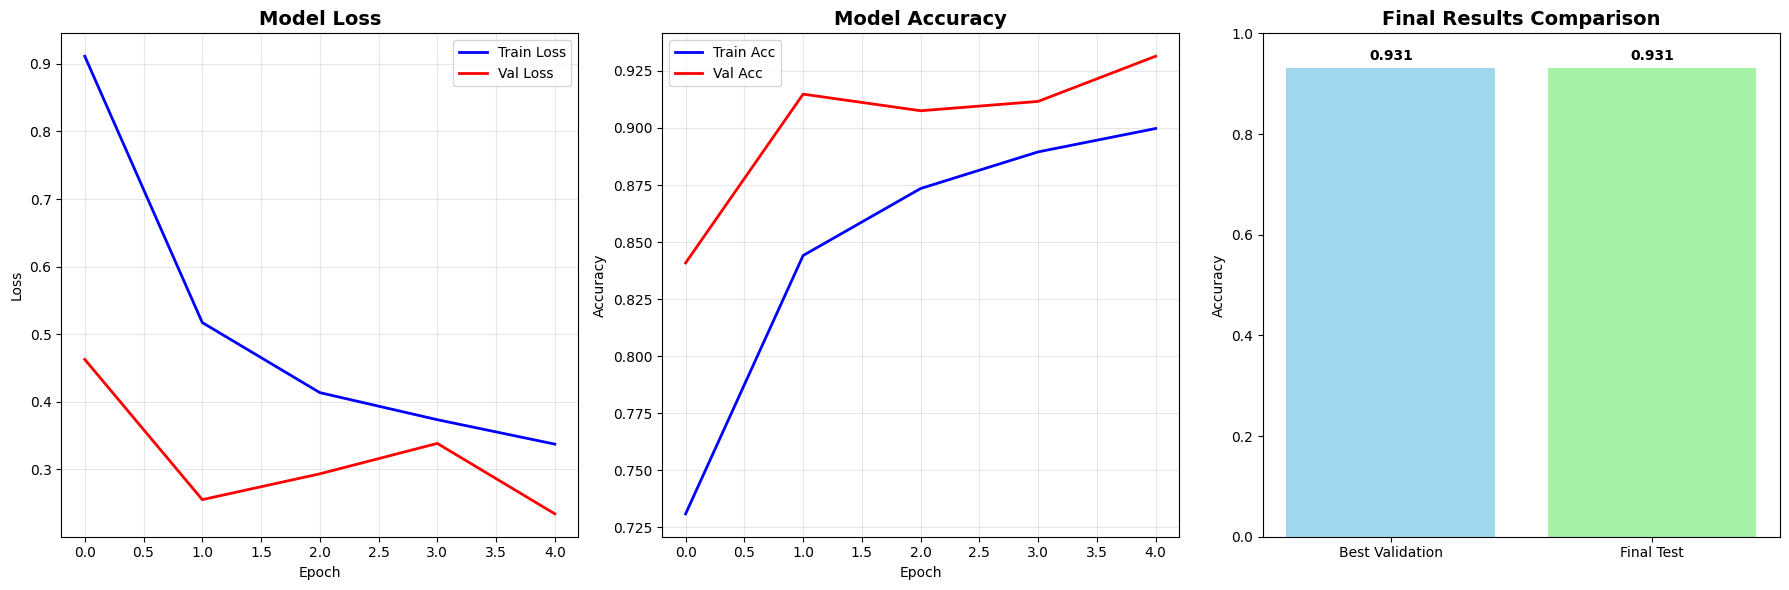


📊 Detailed Classification Report:
                      precision    recall  f1-score   support

      Apple__Healthy       0.95      0.99      0.97       366
       Apple__Rotten       0.95      0.96      0.96       439
     Banana__Healthy       0.98      1.00      0.99       300
      Banana__Rotten       1.00      0.98      0.99       419
 Bellpepper__Healthy       0.64      0.99      0.78        92
  Bellpepper__Rotten       0.66      0.64      0.65        89
     Carrot__Healthy       0.94      0.94      0.94        93
      Carrot__Rotten       0.88      0.76      0.81        87
   Cucumber__Healthy       0.88      0.84      0.86        91
    Cucumber__Rotten       0.84      0.82      0.83        89
      Grape__Healthy       0.83      1.00      0.91        30
       Grape__Rotten       0.96      0.90      0.93        30
      Guava__Healthy       0.94      1.00      0.97        30
       Guava__Rotten       0.91      0.67      0.77        30
     Jujube__Healthy       0.56   

In [40]:
# =====================================
# CELL 10: Evaluate and Visualize
# =====================================

# Load best model for evaluation
print(f"\n📈 Loading best model for final evaluation...")
model.load_state_dict(torch.load('/content/best_freshguard_model.pth'))
model.eval()

# Test evaluation
print("🎯 Final test evaluation...")
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, target in tqdm(test_loader, desc="Testing"):
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Calculate final test accuracy
test_accuracy = accuracy_score(all_targets, all_predictions)

# Print results
print(f"\n🏆 Final Results:")
print(f"  Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"  Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Plot training history
plt.figure(figsize=(18, 6))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss', linewidth=2, color='blue')
plt.plot(history['val_loss'], label='Val Loss', linewidth=2, color='red')
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(history['train_acc'], label='Train Acc', linewidth=2, color='blue')
plt.plot(history['val_acc'], label='Val Acc', linewidth=2, color='red')
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Final results comparison
plt.subplot(1, 3, 3)
results = [best_val_acc, test_accuracy]
labels = ['Best Validation', 'Final Test']
colors = ['skyblue', 'lightgreen']

bars = plt.bar(labels, results, color=colors, alpha=0.8)
plt.title('Final Results Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add value labels on bars
for bar, result in zip(bars, results):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{result:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Classification report
print(f"\n📊 Detailed Classification Report:")
report = classification_report(all_targets, all_predictions, target_names=class_names)
print(report)

In [42]:
# =====================================
# CELL 11: Download Trained Model
# =====================================

# Download the trained model
from google.colab import files

print("📥 Downloading trained model to your computer...")
files.download('/content/best_freshguard_model.pth')

# Create summary
summary = {
    'model_name': 'EfficientNet-B0',
    'num_classes': num_classes,
    'total_params': total_params,
    'best_val_accuracy': best_val_acc,
    'test_accuracy': test_accuracy,
    'training_epochs': len(history['train_loss']),
    'device_used': str(device)
}

print(f"\n✅ FreshGuard AI Training Complete!")
print(f"🎯 Summary:")
for key, value in summary.items():
    print(f"  {key}: {value}")

print(f"\n🎉 Your model is ready to use!")
print(f"📁 Model file downloaded: best_freshguard_model.pth")
print(f"🚀 You can now use this model in your local projects!")


📥 Downloading trained model to your computer...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ FreshGuard AI Training Complete!
🎯 Summary:
  model_name: EfficientNet-B0
  num_classes: 28
  total_params: 4801944
  best_val_accuracy: 0.9314663023679417
  test_accuracy: 0.9312386156648452
  training_epochs: 5
  device_used: cuda

🎉 Your model is ready to use!
📁 Model file downloaded: best_freshguard_model.pth
🚀 You can now use this model in your local projects!
